In [1]:
# ===============================
# 1. Importação de bibliotecas
# ===============================
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt


streetview_link = 'https://www.google.com/maps/@?api=1&map_action=pano&viewpoint={lat},{long}}'

p_greedy = './src/outputs/greedy/'
p_reinforce = './src/outputs/reinforce/'
p_a2c = './src/outputs/a2c/'
p_dqn = './src/outputs/dqn/'
p_ppo = './src/outputs/ppo/'
p_sac = './src/outputs/sac/'

ps = [p_greedy, p_reinforce, p_a2c, p_dqn, p_ppo, p_sac]
algs = ["Greedy", "Reinforce", "A2C", "DQN", "PPO", "SAC"]

# ===============================
# 2. Carregar os dados
# ===============================
candidates_path = "candidates.geojson"
selected_path   = "selected_sensors.geojson"
ranking_path    = "selection_ranking.csv"

candidates = []
selected = []
ranking = []

for p in ps:
    candidates.append(gpd.read_file(p + candidates_path))
    selected.append(gpd.read_file(p + selected_path))
    ranking.append(pd.read_csv(p + ranking_path))
    '''
    print("Arquivos carregados com sucesso!", p)
    print("Candidatos:", candidates[-1].shape)
    print("Selecionados:", selected[-1].shape)
    print("Ranking:", ranking[-1].shape)
    '''



# Build dataframe for comparison
rows = []
for i, alg in enumerate(algs):
    row = {
        "Algorithm": alg,
        "Candidates": len(candidates[i]),
        "Selected": len(selected[i]),
        "Proportion": len(selected[i]) / len(candidates[i]),
        "MarginalGain_Mean": ranking[i]["marginal_gain"].mean(),
        "MarginalGain_Std": ranking[i]["marginal_gain"].std(),
        "MarginalGain_Min": ranking[i]["marginal_gain"].min(),
        "MarginalGain_Max": ranking[i]["marginal_gain"].max()
    }
    rows.append(row)

df = pd.DataFrame(rows)

# Show the dataframe
df

,Algorithm,Candidates,Selected,Proportion,MarginalGain_Mean,MarginalGain_Std,MarginalGain_Min,MarginalGain_Max
0,Greedy,420,50,0.119048,9.740000,2.439555,4,15
1,Reinforce,448,101,0.225446,3.623762,1.848521,1,12
2,A2C,448,101,0.225446,3.623762,1.848521,1,12
3,DQN,448,100,0.223214,3.650000,1.838835,2,12
4,PPO,448,100,0.223214,3.650000,1.838835,2,12
5,SAC,448,100,0.223214,3.650000,1.838835,2,12


In [2]:

def compare_rankings(rankings, alg_names, top_k=10):
    """
    Compare rankings across multiple algorithms.

    Parameters
    ----------
    rankings : list of pd.DataFrame
        Each DataFrame must have at least ["cand_id", "marginal_gain"].
    alg_names : list of str
        Names of the algorithms, same order as `rankings`.
    top_k : int
        Number of top-ranked candidates to compare.

    Returns
    -------
    df_compare : pd.DataFrame
        Side-by-side comparison of candidate IDs and marginal gains.
        Includes flags indicating if all algorithms agree.
    df_long : pd.DataFrame
        Long-format version for plotting or grouping.
    """

    # --- Side-by-side comparison ---
    df_compare = pd.concat(
        [
            rankings[i][0:top_k].rename(
                columns={
                    "cand_id": f"cand_id_{alg_names[i]}",
                    "marginal_gain": f"marginal_gain_{alg_names[i]}"
                }
            ).reset_index(drop=True)
            for i in range(len(rankings))
        ],
        axis=1
    )

    # Flags to check agreement across all algorithms
    cand_cols = [c for c in df_compare.columns if c.startswith("cand_id")]
    gain_cols = [c for c in df_compare.columns if c.startswith("marginal_gain")]

    df_compare["same_cand"] = df_compare[cand_cols].nunique(axis=1) == 1
    df_compare["same_gain"] = df_compare[gain_cols].nunique(axis=1) == 1

    # --- Long-format version (useful for analysis/plots) ---
    df_long = pd.concat(
        [
            rankings[i][0:top_k].assign(alg=alg_names[i], pos=range(top_k))
            for i in range(len(rankings))
        ],
        axis=0
    ).reset_index(drop=True)

    return df_compare, df_long


In [3]:
comp, long = compare_rankings(ranking,algs,5)

In [4]:
comp

,rank,cand_id_Greedy,marginal_gain_Greedy,rank,cand_id_Reinforce,marginal_gain_Reinforce,rank,cand_id_A2C,marginal_gain_A2C,rank,cand_id_DQN,marginal_gain_DQN,rank,cand_id_PPO,marginal_gain_PPO,rank,cand_id_SAC,marginal_gain_SAC,same_cand,same_gain
0,1,c00222,14,1,c00124,12,1,c00124,12,1,c00124,12,1,c00124,12,1,c00124,12,False,False
1,2,c00215,11,2,c00230,3,2,c00230,3,2,c00230,3,2,c00230,3,2,c00230,3,False,False
2,3,c00036,15,3,c00048,9,3,c00048,9,3,c00048,9,3,c00048,9,3,c00048,9,False,False
3,4,c00085,15,4,c00094,9,4,c00094,9,4,c00094,9,4,c00094,9,4,c00094,9,False,False
4,5,c00115,14,5,c00164,8,5,c00164,8,5,c00164,8,5,c00164,8,5,c00164,8,False,False


In [5]:
all_candidates = pd.concat(selected, ignore_index=True)

# Keep only cand_id and geometry, drop duplicates
coords_df = all_candidates[["cand_id", "geometry"]].drop_duplicates().reset_index(drop=True)


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_candidate_positions(rankings, alg_names, coords_df, top_k=None, circle=True):
    """
    Scatter plot of candidate positions for multiple algorithms using coordinates from a geometry string.

    Parameters
    ----------
    rankings : list of pd.DataFrame
        Each DataFrame must have a column ["cand_id"] (and optionally "marginal_gain").
    alg_names : list of str
        Names of the algorithms, same order as `rankings`.
    coords_df : pd.DataFrame
        Must contain ["cand_id", "geometry"], where geometry is a string like 'POINT (x y)'.
    top_k : int, optional
        If specified, only the top_k rows of each DataFrame are plotted.
    circle : bool, default True
        If True, draw a circle around each point.
    """

    # Extract x and y from geometry column (without converting to shapely)
    coords_df = coords_df.copy()  # avoid SettingWithCopyWarning
  

    coords_df["x"] = coords_df["geometry"].apply(lambda p: p.x)
    coords_df["y"] = coords_df["geometry"].apply(lambda p: p.y)


    plt.figure(figsize=(8, 6))

    for i, df in enumerate(rankings):
        df_plot = df.head(top_k).copy() if top_k is not None else df.copy()

        # Merge coordinates
        df_plot = df_plot.merge(coords_df[["cand_id", "x", "y"]], on="cand_id", how="left")

        if circle:
            plt.scatter(
                df_plot["x"],
                df_plot["y"],
                label=alg_names[i],
                s=50*(i+1)^2+i*2,                 # marker size
                facecolors='none',     # hollow circle
                edgecolors='C'+str(i), # different color per algorithm
                linewidths=1.3,
                alpha=0.9
            )
        else:
            plt.scatter(
                df_plot["x"],
                df_plot["y"],
                label=alg_names[i],
                alpha=0.7
            )

    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title("Candidate Positions per Algorithm")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()


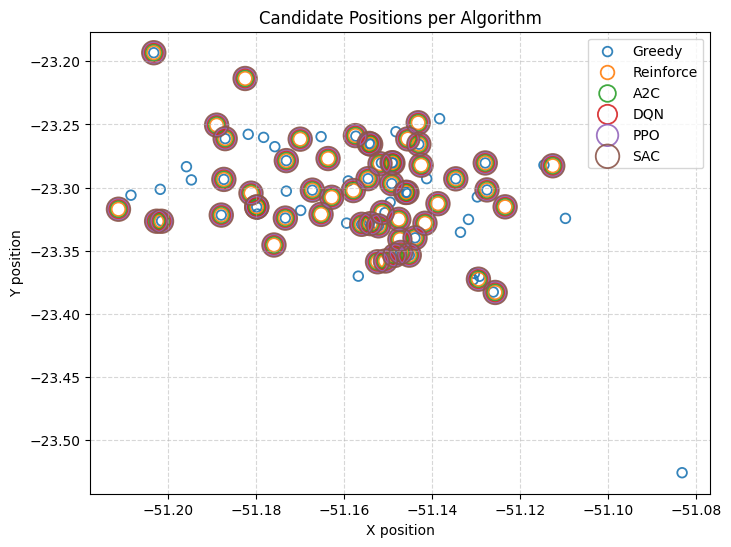

In [7]:

plot_candidate_positions(ranking, algs, coords_df, top_k=50, circle=True)


In [8]:
import folium

# ===============================
# Preparar conjuntos de selecionados dinamicamente
# ===============================

# nomes e cores para cada algoritmo (na mesma ordem do pipeline)
algo_names = ["Greedy", "Reinforce", "A2C", "DQN", "PPO", "SAC"]
algo_colors = ["red", "green", "orange", "brown", "pink", "cyan"]

# criar lista de sets de cand_id
sel_sets = [set(df["cand_id"]) for df in selected]

# interseção de todos (candidatos escolhidos por todos os algoritmos)
sel_all = set.intersection(*sel_sets) if sel_sets else set()

streetview_template = 'https://www.google.com/maps/@?api=1&map_action=pano&viewpoint={lat},{lon}'

# ===============================
# 7. Mapa interativo comparando algoritmos (com sobreposição)
# ===============================
center = [candidates[0].geometry.y.mean(), candidates[0].geometry.x.mean()]
m = folium.Map(location=center, zoom_start=12)

# ---- Todos os candidatos (azul claro) ----
for _, row in candidates[0].iterrows():
    streetview_link = streetview_template.format(lat=row.geometry.y, lon=row.geometry.x)
    popup_html = f'Candidato: {row["cand_id"]}<br>Fonte: {row["source"]}<br>' \
                 f'<a href="{streetview_link}" target="_blank">Street View</a>'
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.4,
        popup=popup_html
    ).add_to(m)

# ---- Selecionados exclusivos por algoritmo ----
for i, df in enumerate(selected):
    algo_name = algo_names[i] if i < len(algo_names) else f"Algo{i}"
    algo_color = algo_colors[i] if i < len(algo_colors) else "gray"

    for _, row in df.iterrows():
        if row["cand_id"] not in sel_all:
            streetview_link = streetview_template.format(lat=row.geometry.y, lon=row.geometry.x)
            popup_html = f'{algo_name} selecionou: {row["cand_id"]}<br>' \
                         f'<a href="{streetview_link}" target="_blank">Street View</a>'
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=6,
                color=algo_color,
                fill=True,
                fill_opacity=0.8,
                popup=popup_html
            ).add_to(m)

# ---- Selecionados por todos (roxo) ----
for _, row in candidates[0][candidates[0]["cand_id"].isin(sel_all)].iterrows():
    streetview_link = streetview_template.format(lat=row.geometry.y, lon=row.geometry.x)
    popup_html = f'Todos selecionaram: {row["cand_id"]}<br>' \
                 f'<a href="{streetview_link}" target="_blank">Street View</a>'
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=8,
        color="purple",
        fill=True,
        fill_opacity=0.9,
        popup=popup_html
    ).add_to(m)


# ===============================
# 9. Exportar versão do mapa
# ===============================
m.save("./docs/sensor_comparison_map.html")
print("Mapa salvo em sensor_comparison_map.html")


Mapa salvo em sensor_comparison_map.html
